In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import torchsummary
import torchsummaryX
import tqdm
import torchnet

In [2]:
BS = 128
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
train_data = datasets.CIFAR10('cifar10', transform=transforms.ToTensor(), train=True)

test_data = datasets.CIFAR10('cifar10', transform=transforms.ToTensor(), train=False)

In [4]:
num_workers = 1

train_loader = DataLoader(train_data, batch_size=BS, shuffle=True, num_workers=num_workers, pin_memory=False)

test_loader = DataLoader(test_data, batch_size=BS, shuffle=True, num_workers=num_workers, pin_memory=False)

## Use ResNet18 as pretrained model

ResNet18 use at least 228x228, 32x32 --> 228x228 needs 3 upsampling

In [5]:
resnet18 = torchvision.models.resnet.resnet18(pretrained=True)

_ = torchsummary.summary(resnet18, (3, 228, 228))

------------------------------------------------------------------------------------------
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 114, 114]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 114, 114]        128
├─ReLU: 1-3                              [-1, 64, 114, 114]        --
├─MaxPool2d: 1-4                         [-1, 64, 57, 57]          --
├─Sequential: 1-5                        [-1, 64, 57, 57]          --
|    └─BasicBlock: 2-1                   [-1, 64, 57, 57]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 57, 57]          36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 57, 57]          128
|    |    └─ReLU: 3-3                    [-1, 64, 57, 57]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 57, 57]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 57, 57]          128
|    |    └─ReLU: 3-6                    [-1, 64, 

In [6]:
upsampling = nn.Sequential(
    nn.Upsample(scale_factor=2.0),
    nn.Upsample(scale_factor=2.0),
    nn.Upsample(scale_factor=2.0),
)

model = nn.Sequential(
    upsampling,
    resnet18,
    nn.Linear(1000, 10),
)

_ = torchsummary.summary(model, (3, 32, 32), verbose=2)

------------------------------------------------------------------------------------------
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 256, 256]         --
|    └─Upsample: 2-1                     [-1, 3, 64, 64]           --
|    └─Upsample: 2-2                     [-1, 3, 128, 128]         --
|    └─Upsample: 2-3                     [-1, 3, 256, 256]         --
├─ResNet: 1-2                            [-1, 1000]                --
|    └─conv1.weight
|    └─bn1.weight
|    └─layer1.0.conv1.weight
|    └─layer1.0.bn1.weight
|    └─layer1.0.conv2.weight
|    └─layer1.0.bn2.weight
|    └─layer1.1.conv1.weight
|    └─layer1.1.bn1.weight
|    └─layer1.1.conv2.weight
|    └─layer1.1.bn2.weight
|    └─layer2.0.conv1.weight
|    └─layer2.0.bn1.weight
|    └─layer2.0.conv2.weight
|    └─layer2.0.bn2.weight
|    └─layer2.0.downsample.0.weight
|    └─layer2.0.downsample.1.weight
|    └─layer2.1.conv1.weight
|    └─la

Preview Module

tensor([[-0.0448,  0.5688,  1.4352,  ..., -0.9166,  0.4587,  0.2677],
        [-0.4600,  0.6782,  1.6008,  ...,  0.5295,  0.1328, -1.0395],
        [-0.8814, -0.9512, -1.6401,  ..., -0.8540,  0.2468, -1.0468],
        ...,
        [-2.0456,  1.8195, -3.7675,  ...,  0.4203,  1.6203, -0.9703],
        [-1.0944, -0.4017,  0.9233,  ..., -1.4441, -1.2636,  0.7242],
        [-0.6598, -0.0928, -0.1362,  ...,  0.1990,  0.3489, -0.7188]],
       device='cuda:0', grad_fn=<AddmmBackward>)


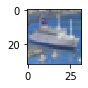

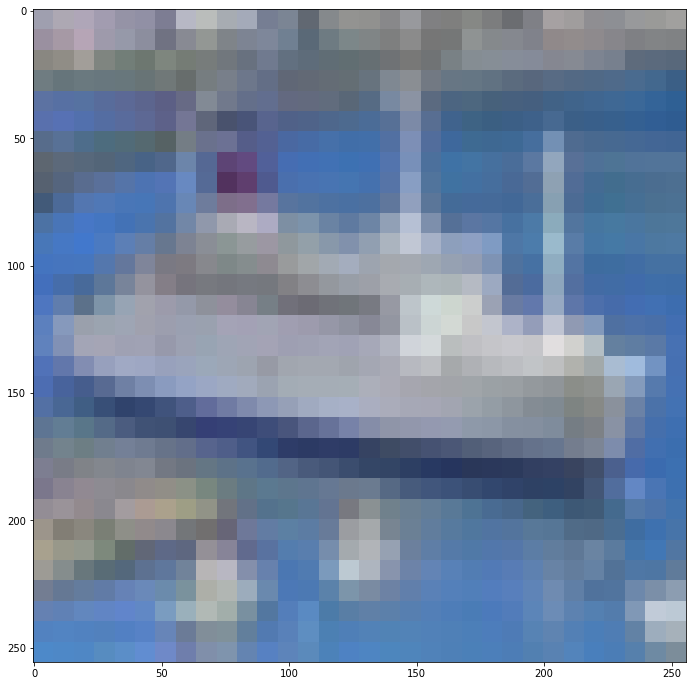

In [7]:
for data, target in train_loader:
    print(model(data.cuda()))
    plt.figure(figsize=(data.shape[-1] // 20, data.shape[-1] // 20))
    plt.imshow(data[0].numpy().transpose(1, 2, 0))
    plt.show()
    data = upsampling(data)
    plt.figure(figsize=(data.shape[-1] // 20, data.shape[-1] // 20))
    plt.imshow(data[0].numpy().transpose(1, 2, 0))
    plt.show()
    break

In [8]:
lr = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

In [9]:
def test(model):
    acc = 0
    model.eval()
    for (data, target) in test_loader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        output = model(data)
        predict = output.max(dim=1).indices
        acc += sum((predict == target).detach()).item()
    print(round(acc *100/len(test_data.data)), "%")
test(model)

8 %


In [10]:
import time
EPOCHS = 10
for e in range(EPOCHS):
    t0 = time.time()
    total_loss = []
    model.train()
    for bid, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        output = model(data)
        optimizer.zero_grad()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss.append(loss.item())
        if (bid+1) % (len(train_loader)//10) == 0:
            print("Batch:", bid+1, "Loss:", np.mean(total_loss), "Time:", time.time() - t0)
    print("Epoch:", e+1, "Loss:", np.mean(total_loss), "Time:", time.time() - t0)

    test(model)

Batch: 39 Loss: 1.1385304285929754 Time: 9.173370599746704
Batch: 78 Loss: 0.9154954590858557 Time: 18.213894605636597
Batch: 117 Loss: 0.8128735425635281 Time: 27.267330408096313
Batch: 156 Loss: 0.7441686737613801 Time: 36.3242609500885
Batch: 195 Loss: 0.6920492384678278 Time: 45.399641275405884
Batch: 234 Loss: 0.6500839343310422 Time: 54.490437507629395
Batch: 273 Loss: 0.6232096458420212 Time: 63.59925985336304
Batch: 312 Loss: 0.5980029090379293 Time: 72.70091104507446
Batch: 351 Loss: 0.5742435416689625 Time: 81.80264329910278
Batch: 390 Loss: 0.5562612862541125 Time: 90.92044043540955
Epoch: 1 Loss: 0.5561445505189164 Time: 91.14340567588806
81 %
Batch: 39 Loss: 0.288738136108105 Time: 9.248161792755127
Batch: 78 Loss: 0.2803475954211675 Time: 18.38410496711731
Batch: 117 Loss: 0.2816688707496366 Time: 27.513606309890747
Batch: 156 Loss: 0.28205457157813585 Time: 36.64748930931091
Batch: 195 Loss: 0.2863277588899319 Time: 45.79072380065918
Batch: 234 Loss: 0.28922138586003554 